# `analysis_modelling.ipynb`

The goal of this notebook is to answer the question:

**"How many customer orders go partially or fully unfulfilled - and what inventory or supplier-related factors are driving these failures?"**

## Setup

### Install and Load Libraries

In [ ]:
install.packages(c("tidyverse", "lubridate", "janitor", "jsonlite", "ggeffects", "randomForest", "splines"))

Installing packages into 'C:/Users/James/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)

Warning message:
"package 'splines' is a base package, and should not be updated"


package 'tidyverse' successfully unpacked and MD5 sums checked
package 'lubridate' successfully unpacked and MD5 sums checked
package 'janitor' successfully unpacked and MD5 sums checked
package 'jsonlite' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'jsonlite'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\James\AppData\Local\R\win-library\4.5\00LOCK\jsonlite\libs\x64\jsonlite.dll to C:\Users\James\AppData\Local\R\win-library\4.5\jsonlite\libs\x64\jsonlite.dll: Permission denied"
Warning message:
"restored 'jsonlite'"


package 'ggeffects' successfully unpacked and MD5 sums checked
package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\James\AppData\Local\Temp\Rtmp4uhjUL\downloaded_packages


In [ ]:
library(tidyverse)
library(lubridate)
library(janitor)
library(jsonlite)
library(ggeffects)
library(randomForest)
library(splines)

Warning message:
"package 'tidyverse' was built under R version 4.5.1"
Warning message:
"package 'ggplot2' was built under R version 4.5.1"
Warning message:
"package 'tibble' was built under R version 4.5.1"
Warning message:
"package 'tidyr' was built under R version 4.5.1"
Warning message:
"package 'readr' was built under R version 4.5.1"
Warning message:
"package 'purrr' was built under R version 4.5.1"
Warning message:
"package 'dplyr' was built under R version 4.5.1"
Warning message:
"package 'stringr' was built under R version 4.5.1"
Warning message:
"package 'forcats' was built under R version 4.5.1"
Warning message:
"package 'lubridate' was built under R version 4.5.1"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ──────────────────────────────────────

### Load and Clean Data

Our data (minus the customers table) is loaded in. The config JSON is also split into two separate dataframes relating to items and suppliers.

In [4]:
# Core simulation outputs
orders <- read_csv("data/orders.csv") %>% clean_names()
order_items <- read_csv("data/order_items.csv") %>% clean_names()
items <- read_csv("data/items.csv") %>% clean_names()
suppliers <- read_csv("data/suppliers.csv") %>% clean_names()
inventory <- read_csv("data/inventory.csv") %>% clean_names()
inventory_history <- read_csv("data/inventory_history.csv") %>% clean_names()
fulfillment_log <- read_csv("data/fulfillment_log.csv") %>% clean_names()

# Simulation config
config <- fromJSON("data/simulation_config.json")
items_config <- as_tibble(config$items)
suppliers_config <- as_tibble(config$suppliers)

Rows: 20129 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): order_status
dbl  (2): order_id, customer_id
date (1): order_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60847 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): order_item_id, order_id, item_id, supplier_id, quantity, fulfilled...
date (1): fulfilled_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 50 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, category
dbl (2): item_id, unit_price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or

This transposes the JSON data into something more usable.

In [5]:
items_config <- config$items %>%
  imap_dfr(~ as_tibble(.x) %>% mutate(item_id = as.integer(.y)))

suppliers_config <- config$suppliers %>%
  imap_dfr(~ as_tibble(.x) %>% mutate(supplier_id = as.integer(.y)))

### Feature Construction

This combines our orders and order_items data as well as adds an `item_status` column for future analysis. An additional dataframe that excludes ongoing orders (orders within the last 14 days of simulation end-time) is also created.

In [6]:
cutoff_date <- max(orders$order_date, na.rm = TRUE) - days(14)

order_item_details <- order_items %>%
  left_join(orders, by = "order_id") %>%
  mutate(
    item_status = case_when(
      fulfilled_quantity == quantity ~ "Fulfilled",
      order_date <= cutoff_date      ~ "Failed",
      TRUE                           ~ "Ongoing"
    )
  )


order_item_modelling <- order_item_details %>%
  filter(item_status != "Ongoing")


This adds those item and supplier weights and failure rates from the config file to our orders that aren't ongoing.

In [8]:
order_item_augmented <- order_item_modelling %>%
  left_join(items_config, by = "item_id") %>%
  left_join(suppliers_config, by = "supplier_id", suffix = c("", "_supplier")) %>%
  rename(
    item_failure_rate = failure_rate,
    item_restock_weight = restock_weight,
    supplier_failure_rate = failure_rate_supplier,
    supplier_fulfillment_weight = fulfillment_weight
  )


### Feature Engineering

It'll be useful for analysis to have averages of `quantity_on_hand` , `backlog_unfulfilled_qty` as well as a count of `stockouts` for each item and supplier pair.

In [10]:
inventory_summary <- inventory_history %>%
  group_by(item_id, supplier_id) %>%
  summarise(
    avg_quantity_on_hand = mean(quantity_on_hand, na.rm = TRUE),
    avg_backlog = mean(backlog_unfulfilled_qty, na.rm = TRUE),
    stockouts = sum(quantity_on_hand == 0),
    .groups = "drop"
  )

# Join into the main order item table
order_item_final <- order_item_augmented %>%
  left_join(inventory_summary, by = c("item_id", "supplier_id"))


In [12]:
glimpse(order_item_final)

Rows: 59,820
Columns: 23
$ order_item_id               <dbl> 18041, 18042, 18043, 38, 2, 30, 14, 42, 7,…
$ order_id                    <dbl> 5975, 5975, 5975, 14, 1, 11, 6, 15, 4, 13,…
$ item_id                     <dbl> 50, 21, 19, 21, 12, 31, 20, 41, 45, 17, 30…
$ supplier_id                 <dbl> 3, 8, 8, 3, 7, 5, 9, 7, 5, 2, 1, 1, 8, 6, …
$ quantity                    <dbl> 4, 4, 4, 5, 3, 2, 3, 4, 5, 3, 3, 2, 5, 5, …
$ fulfilled_quantity          <dbl> 0, 0, 0, 5, 3, 2, 3, 4, 5, 3, 3, 2, 5, 5, …
$ fulfilled_date              <date> NA, NA, NA, 2025-08-01, 2025-08-01, 2025-…
$ customer_id                 <dbl> 77, 77, 77, 23, 110, 1, 57, 93, 177, 111, …
$ order_date                  <date> 2025-11-22, 2025-11-22, 2025-11-22, 2025-…
$ order_status                <chr> "expired", "expired", "expired", "fulfille…
$ item_status                 <chr> "Failed", "Failed", "Failed", "Fulfilled",…
$ name                        <chr> "Sell", "Hard", "Manage", "Hard", "Reason"…
$ category     

Having the full `order_items` data with these new features from inventory history will prove useful.

## Visual Diagnostics

### Fulfillment Outcomes by the Main Levers

The four main levers that can be tuned in `data_generator.py` before running the simulation are:

- `supplier_fulfillment_weight` - used in the 'fulfill order' event to determine which supplier will attempt to fulfill an order
- `supplier_failure_rate` - once a supplier is picked its failure rate is used to determine whether the attempt will be successful
- `item_failure_rate` - used alongside the supplier failure rate for the same purpose
- `item_restock_weight` - used to determine which item will be chosen during the 'restock' event where one supplier restocks an item

Let's take a look at boxplots that show their relationships with fulfillment outcomes.

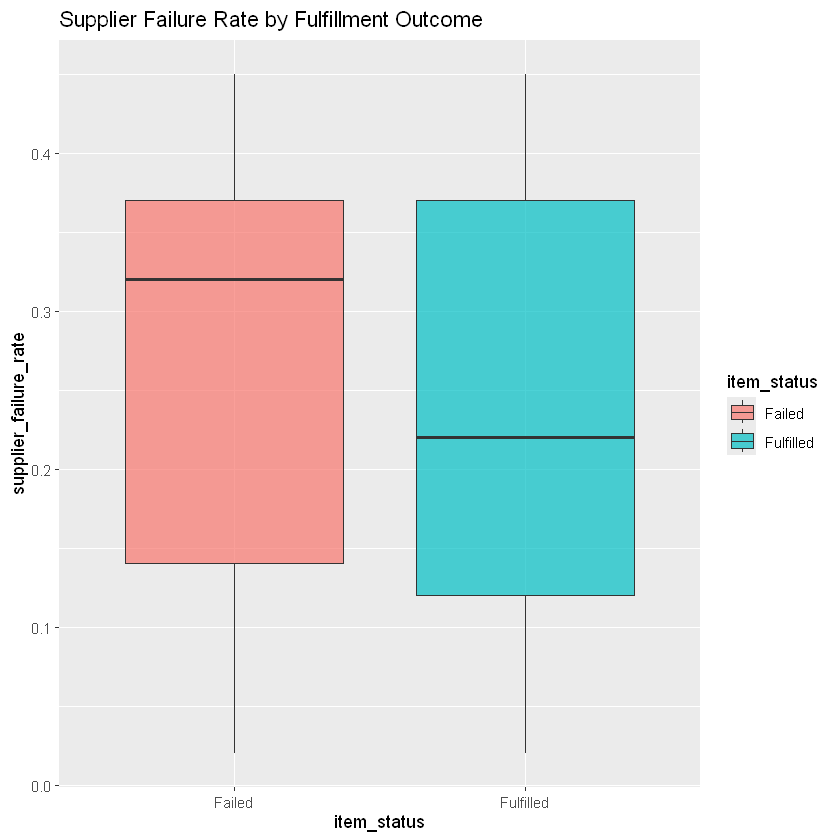

In [15]:
ggplot(order_item_final, aes(x = item_status, y = supplier_failure_rate, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Supplier Failure Rate by Fulfillment Outcome")


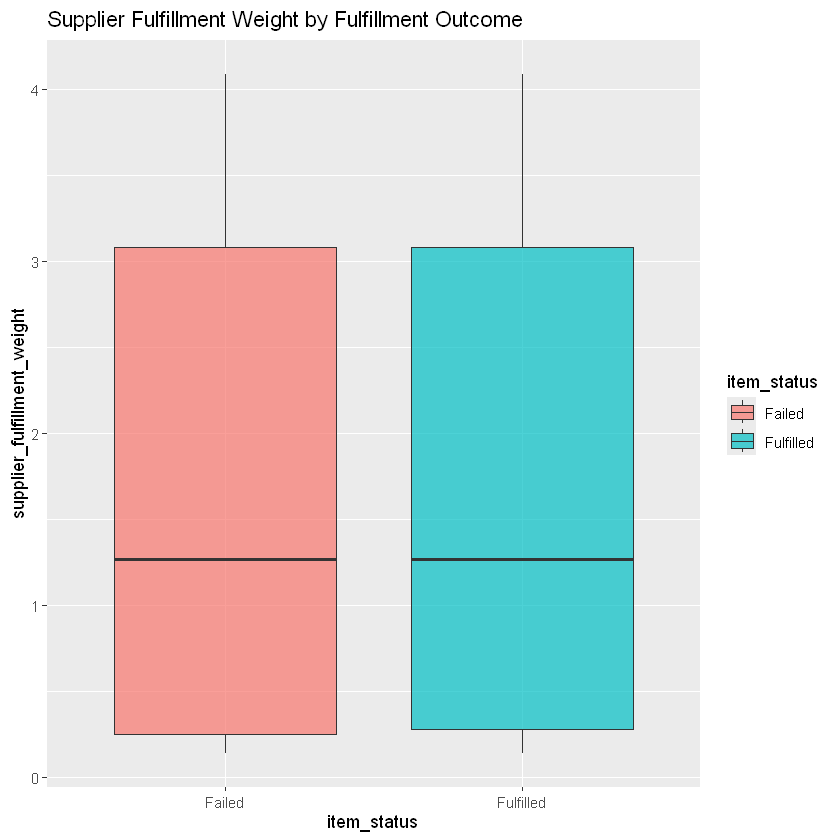

In [16]:
ggplot(order_item_final, aes(x = item_status, y = supplier_fulfillment_weight, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Supplier Fulfillment Weight by Fulfillment Outcome")

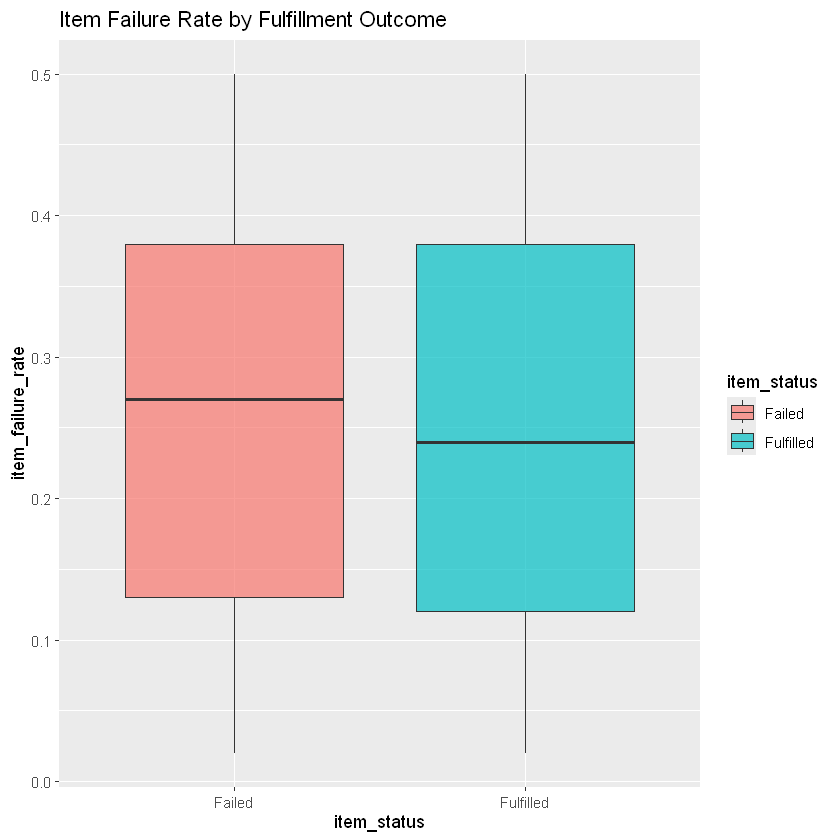

In [17]:
ggplot(order_item_final, aes(x = item_status, y = item_failure_rate, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Item Failure Rate by Fulfillment Outcome")

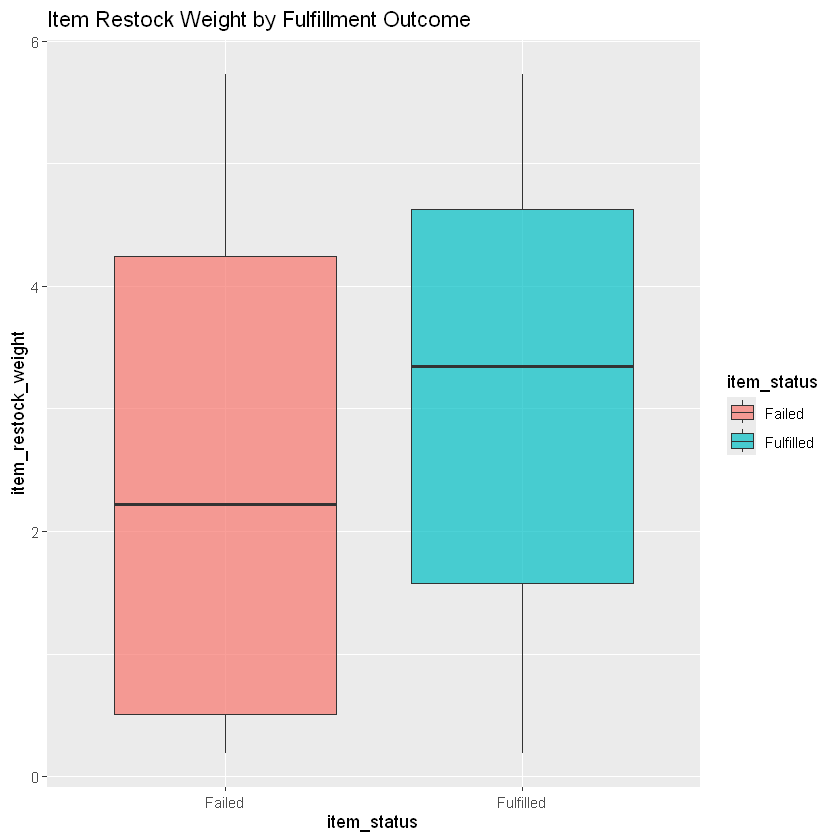

In [18]:
ggplot(order_item_final, aes(x = item_status, y = item_restock_weight, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Item Restock Weight by Fulfillment Outcome")

From a visual perspective the biggest predictors here seem to be `supplier_failure_rate` (quite a difference in medians) and `item_restock_weight` (big difference in 1st quartile and median values). I'll also look at our new features created from `fulfillment_log.csv` and `inventory_history.csv` data to see how they relate to fulfillment outcomes.

### Fulfillment Outcomes by Inventory Strain Features

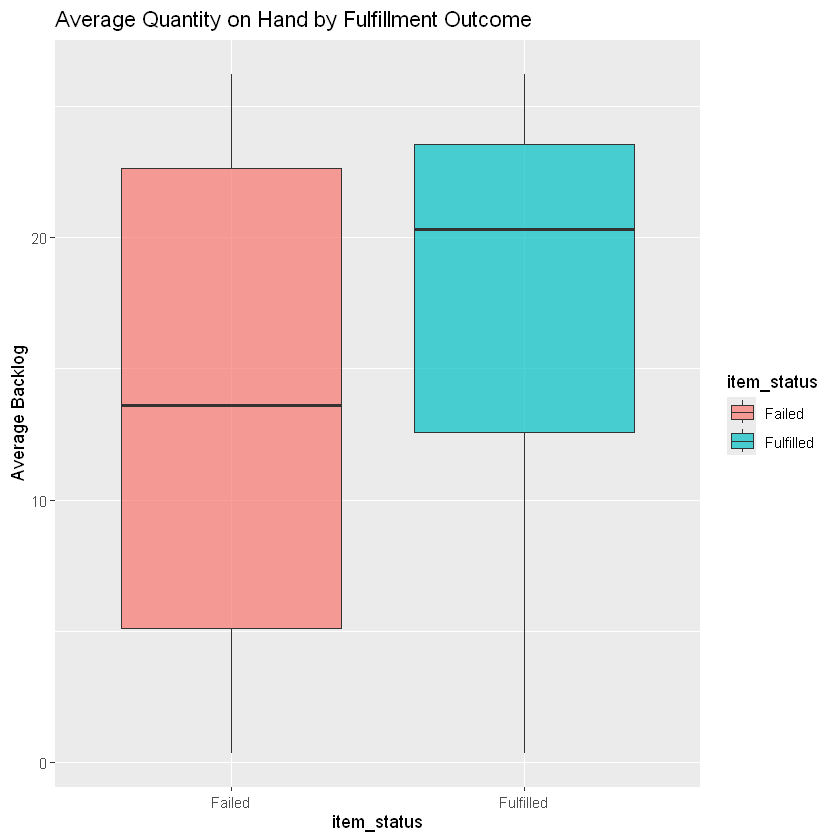

In [20]:
ggplot(order_item_final, aes(x = item_status, y = avg_quantity_on_hand, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Average Quantity on Hand by Fulfillment Outcome", y = "Average Backlog")

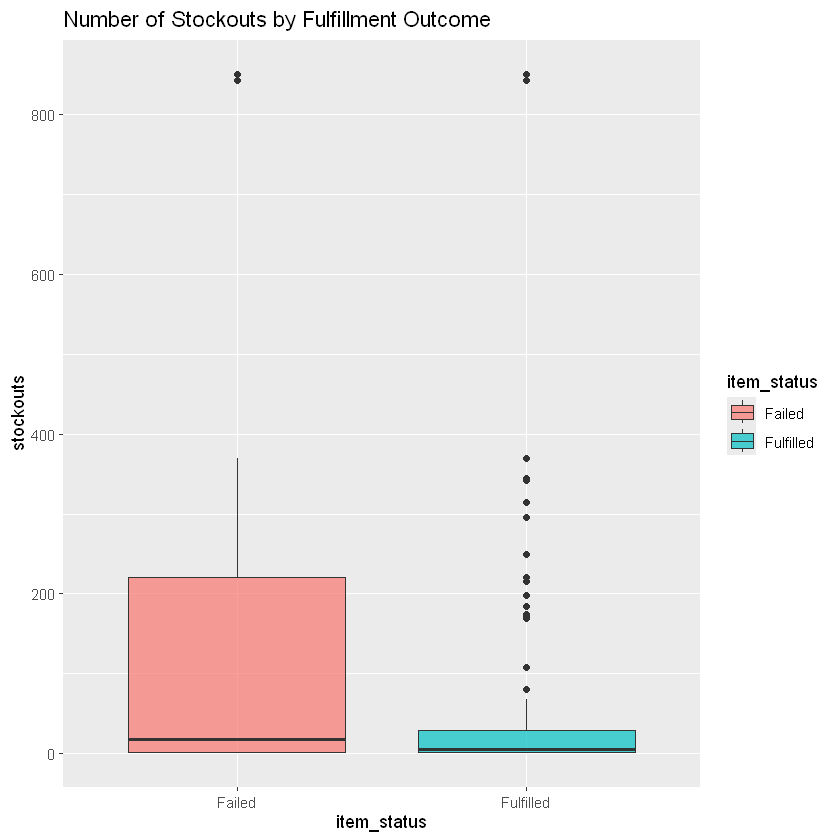

In [21]:
ggplot(order_item_final, aes(x = item_status, y = stockouts, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Number of Stockouts by Fulfillment Outcome")

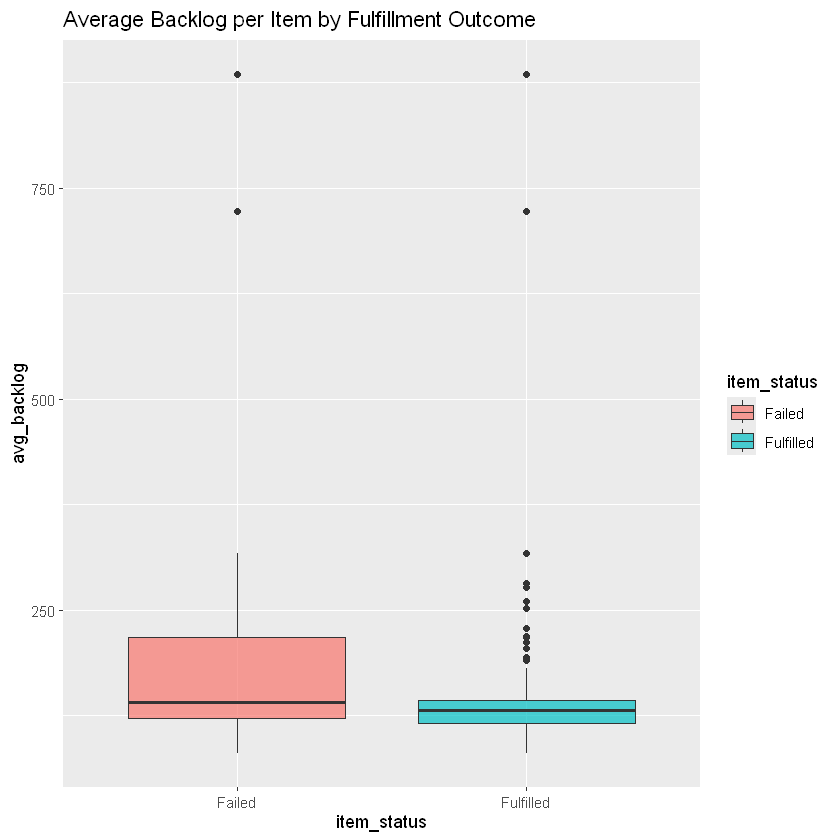

In [22]:
ggplot(order_item_final, aes(x = item_status, y = avg_backlog, fill = item_status)) +
  geom_boxplot(alpha = 0.7) +
  labs(title = "Average Backlog per Item by Fulfillment Outcome")

The most striking plot of these three is the `avg_quantity_on_hand` boxplot which shows quite a difference between the quantities on hand of items in orders that are fulfilled versus those that are failed.

## Modelling

### Order Level Fulfillment Outcomes

In [23]:
order_item_final <- order_item_final %>%
  mutate(fulfilled_binary = if_else(order_status == "fulfilled", 1, 0))

logistic_fulfillment <- glm(
  fulfilled_binary ~ item_failure_rate + item_restock_weight + supplier_failure_rate + supplier_fulfillment_weight + avg_quantity_on_hand + avg_backlog + stockouts,
  data = order_item_final,
  family = binomial()
)

summary(logistic_fulfillment)


Call:
glm(formula = fulfilled_binary ~ item_failure_rate + item_restock_weight + 
    supplier_failure_rate + supplier_fulfillment_weight + avg_quantity_on_hand + 
    avg_backlog + stockouts, family = binomial(), data = order_item_final)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  1.2496178  0.0487120  25.653   <2e-16 ***
item_failure_rate            0.0407027  0.0618425   0.658   0.5104    
item_restock_weight          0.0139946  0.0139269   1.005   0.3150    
supplier_failure_rate       -0.0755647  0.0671287  -1.126   0.2603    
supplier_fulfillment_weight -0.0045197  0.0061953  -0.730   0.4657    
avg_quantity_on_hand        -0.0069563  0.0038351  -1.814   0.0697 .  
avg_backlog                 -0.0035743  0.0003203 -11.158   <2e-16 ***
stockouts                   -0.0003952  0.0002470  -1.600   0.1095    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial fam

In relation to fulfillment outcomes this suggests the following:

- Item and supplier failure rates are significant predictors
- Higher `avg_backlog` strongly predicts non-fulfillment
- Fulfillment and restock weights are not predictive

I'll now run a model with interaction terms to further investigate these results.

In [24]:
logistic_fulfillment_interaction <- glm(
    fulfilled_binary ~ item_failure_rate * avg_backlog, 
    data = order_item_final,
    family = binomial()
)

summary(logistic_fulfillment_interaction)


Call:
glm(formula = fulfilled_binary ~ item_failure_rate * avg_backlog, 
    family = binomial(), data = order_item_final)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    1.0748306  0.0527969  20.358   <2e-16 ***
item_failure_rate              0.4408344  0.1990268   2.215   0.0268 *  
avg_backlog                   -0.0032141  0.0003558  -9.035   <2e-16 ***
item_failure_rate:avg_backlog -0.0026857  0.0012990  -2.068   0.0387 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 78020  on 59819  degrees of freedom
Residual deviance: 76209  on 59816  degrees of freedom
AIC: 76217

Number of Fisher Scoring iterations: 4


This suggests that at low backlog - item failure rate won't hurt fulfillment outcomes much, but at high backlog the failure-prone items are much more likely to not be fulfilled. I'll visualise this.

In [25]:
summary(order_item_final$item_failure_rate)
summary(order_item_final$avg_backlog)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0200  0.1200  0.2400  0.2409  0.3800  0.5000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  80.31  115.60  130.90  154.09  146.25  884.94 

I'll use these for the predictions/plot

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


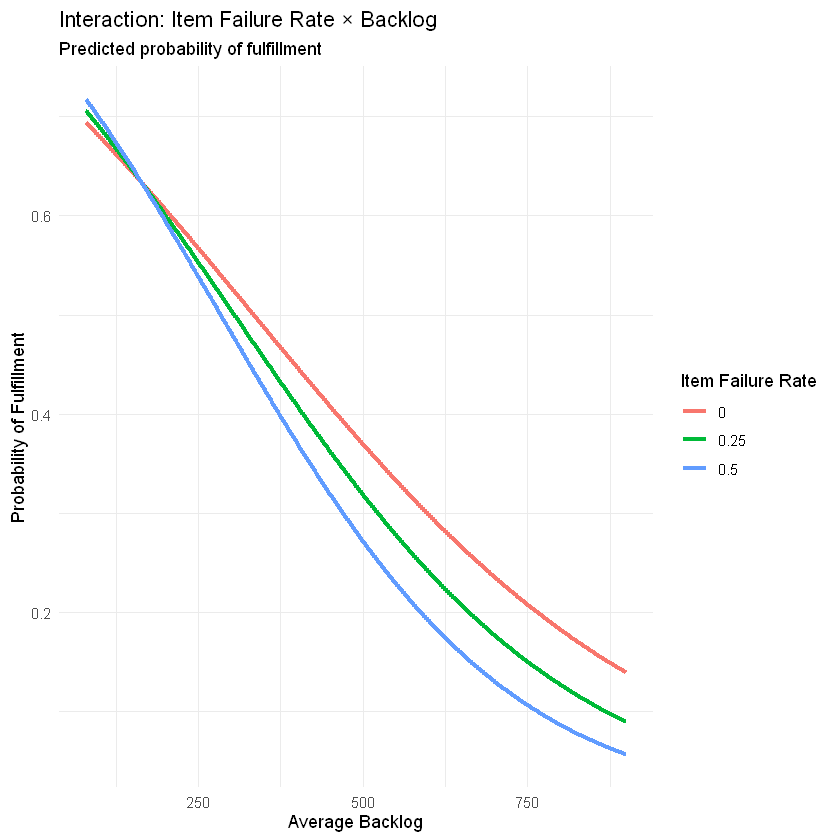

In [26]:
# Generate predicted probabilities
preds <- ggpredict(logistic_fulfillment_interaction, terms = c("avg_backlog [80:900]", "item_failure_rate [0, 0.25, 0.5]"))

# Plot
ggplot(preds, aes(x = x, y = predicted, color = group)) +
  geom_line(size = 1.2) +
  labs(
    title = "Interaction: Item Failure Rate × Backlog",
    subtitle = "Predicted probability of fulfillment",
    x = "Average Backlog",
    y = "Probability of Fulfillment",
    color = "Item Failure Rate"
  ) +
  theme_minimal()


It looks like the impact you'd expect `avg_backlog` to have on fulfillment success between the different item failure rates only becomes significant once you surpass around 200 items backlogged. This isn't too useful as it's only the high outliers that fall beyond that point. Most of the items have backlogs of less than 150 which the plot shows the behaviour to be opposite of what is expected.

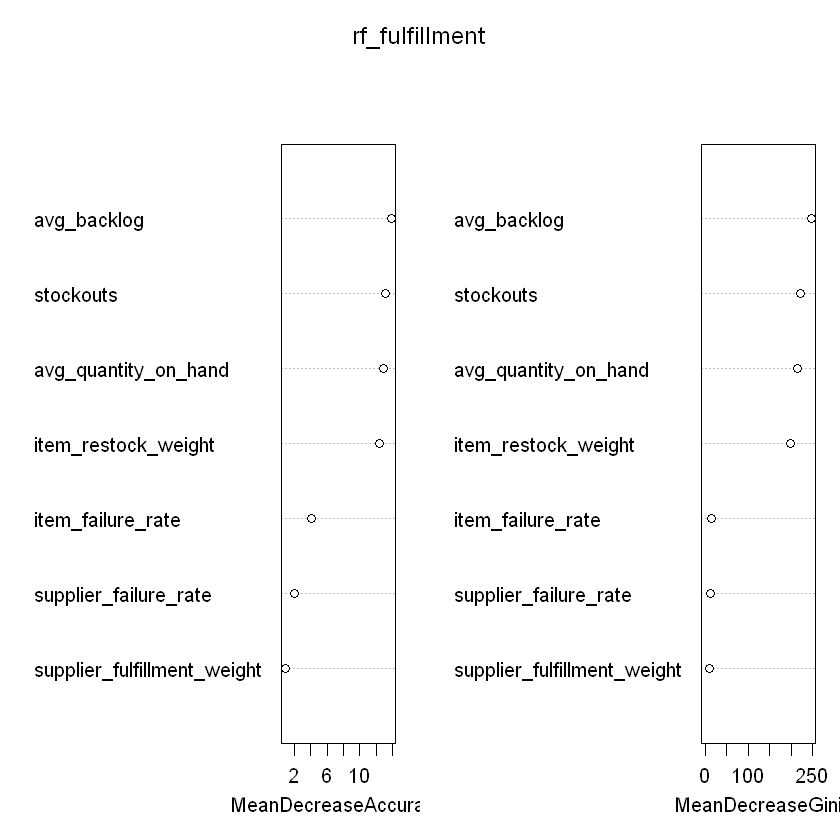

In [27]:
rf_fulfillment <- randomForest(
  as.factor(fulfilled_binary) ~ item_failure_rate + supplier_failure_rate + 
    item_restock_weight + supplier_fulfillment_weight +
    avg_quantity_on_hand + avg_backlog + stockouts,
  data = order_item_final,
  importance = TRUE
)

# Plot variable importance
varImpPlot(rf_fulfillment)


As seen in the boxplots from the visual diagnostics section and the initial logistic regression model - the strongest predictors seem to be the constructed features that relate to inventory strain rather than the config variables relating to supplier and item specific weights. With this in mind I'll now look further into these strain features.

In [28]:
order_level_df <- order_item_final %>%
  group_by(order_id) %>%
  summarise(
    n_items = n(),
    n_fulfilled = sum(fulfilled_binary),
    percent_fulfilled = n_fulfilled / n_items,
    order_fulfilled = as.integer(n_fulfilled == n_items),  # 1 if all items fulfilled
    
    avg_quantity_on_hand = mean(avg_quantity_on_hand),
    avg_backlog = mean(avg_backlog, na.rm = TRUE),
    total_stockouts = sum(stockouts, na.rm = TRUE),
    
    first_item_date = min(order_date),
    .groups = "drop"
  )


In [29]:
logistic_order_level_fulfillment <- glm(
  order_fulfilled ~ total_stockouts + avg_quantity_on_hand + avg_backlog,
  data = order_level_df,
  family = binomial()
)

summary(logistic_order_level_fulfillment)


Call:
glm(formula = order_fulfilled ~ total_stockouts + avg_quantity_on_hand + 
    avg_backlog, family = binomial(), data = order_level_df)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.1725601  0.1132168  28.022   <2e-16 ***
total_stockouts      -0.0050968  0.0001216 -41.919   <2e-16 ***
avg_quantity_on_hand -0.0732029  0.0047954 -15.265   <2e-16 ***
avg_backlog           0.0006579  0.0003478   1.892   0.0585 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23402  on 19990  degrees of freedom
Residual deviance: 19456  on 19987  degrees of freedom
AIC: 19464

Number of Fisher Scoring iterations: 4


`geom_smooth()` using formula = 'y ~ x'


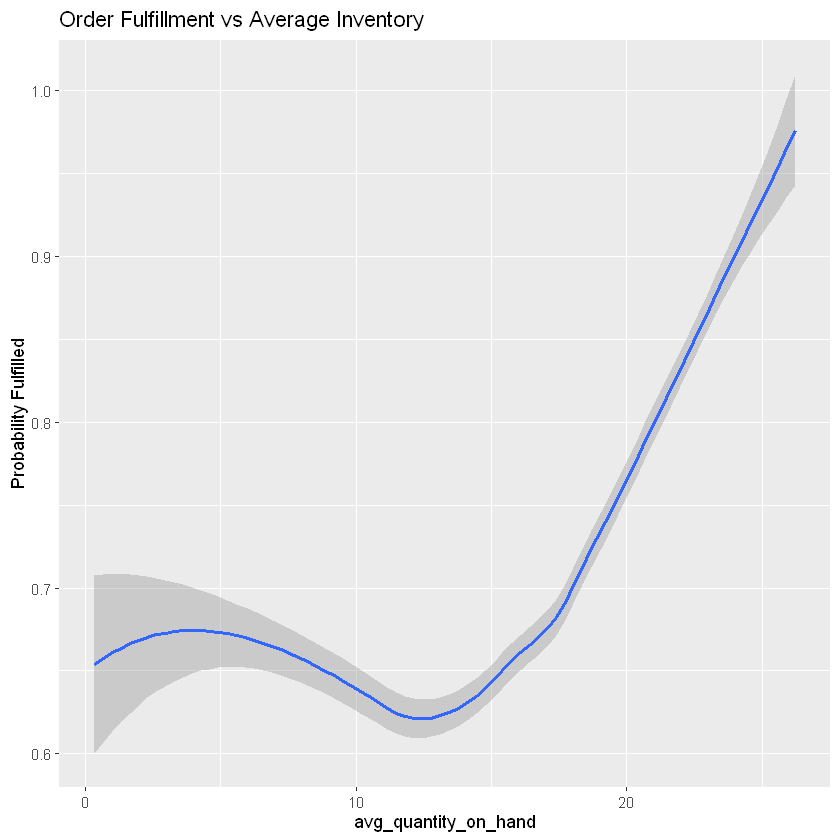

In [30]:
order_level_df %>%
  ggplot(aes(x = avg_quantity_on_hand, y = order_fulfilled)) +
  geom_smooth(method = "loess") +
  labs(title = "Order Fulfillment vs Average Inventory", y = "Probability Fulfilled")


Perhaps it'll be better to focus on the nonlinearity aspect of these results.

In [31]:
nonlinear_fulfillment <- glm(
  order_fulfilled ~ poly(avg_quantity_on_hand, 2) + total_stockouts + avg_backlog,
  family = binomial(),
  data = order_level_df
)

summary(nonlinear_fulfillment)


Call:
glm(formula = order_fulfilled ~ poly(avg_quantity_on_hand, 2) + 
    total_stockouts + avg_backlog, family = binomial(), data = order_level_df)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     2.443e+00  6.446e-02  37.897  < 2e-16 ***
poly(avg_quantity_on_hand, 2)1 -5.966e+01  3.915e+00 -15.241  < 2e-16 ***
poly(avg_quantity_on_hand, 2)2  5.062e+01  3.477e+00  14.559  < 2e-16 ***
total_stockouts                -4.274e-03  1.320e-04 -32.383  < 2e-16 ***
avg_backlog                    -3.549e-03  4.642e-04  -7.644  2.1e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23402  on 19990  degrees of freedom
Residual deviance: 19224  on 19986  degrees of freedom
AIC: 19234

Number of Fisher Scoring iterations: 4


The U-Shape seems to be modelled well by the polynomial terms.

In [32]:
spline_fulfillment <- glm(
  order_fulfilled ~ ns(avg_quantity_on_hand, df = 4) + total_stockouts + avg_backlog,
  family = binomial(),
  data = order_level_df
)

summary(spline_fulfillment)


Call:
glm(formula = order_fulfilled ~ ns(avg_quantity_on_hand, df = 4) + 
    total_stockouts + avg_backlog, family = binomial(), data = order_level_df)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        3.8146669  0.2448004  15.583  < 2e-16 ***
ns(avg_quantity_on_hand, df = 4)1 -2.1641551  0.1921885 -11.261  < 2e-16 ***
ns(avg_quantity_on_hand, df = 4)2 -2.2601800  0.1556823 -14.518  < 2e-16 ***
ns(avg_quantity_on_hand, df = 4)3 -1.8962405  0.4364215  -4.345 1.39e-05 ***
ns(avg_quantity_on_hand, df = 4)4 -0.3531245  0.1666932  -2.118   0.0341 *  
total_stockouts                   -0.0049961  0.0001453 -34.387  < 2e-16 ***
avg_backlog                       -0.0006751  0.0004880  -1.383   0.1666    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23402  on 19990  degrees of freedom
Residual deviance: 19040  on 19984

This spline model beats the quadractic polynomials model on fit and flexibility, but both capture the nonlinearity of `avg_quantity_on_hand` well.

In [33]:
# Create a grid of avg_quantity_on_hand values from your actual range
inventory_seq <- seq(min(order_level_df$avg_quantity_on_hand, na.rm = TRUE),
                     max(order_level_df$avg_quantity_on_hand, na.rm = TRUE),
                     length.out = 200)

# Fix the other predictors at typical values (mean or median)
mean_stockouts <- mean(order_level_df$total_stockouts, na.rm = TRUE)
mean_backlog <- mean(order_level_df$avg_backlog, na.rm = TRUE)

# Create new data for prediction
prediction_df <- data.frame(
  avg_quantity_on_hand = inventory_seq,
  total_stockouts = mean_stockouts,
  avg_backlog = mean_backlog
)

# Predict fulfillment probabilities
prediction_df$predicted_prob <- predict(spline_fulfillment, newdata = prediction_df, type = "response")


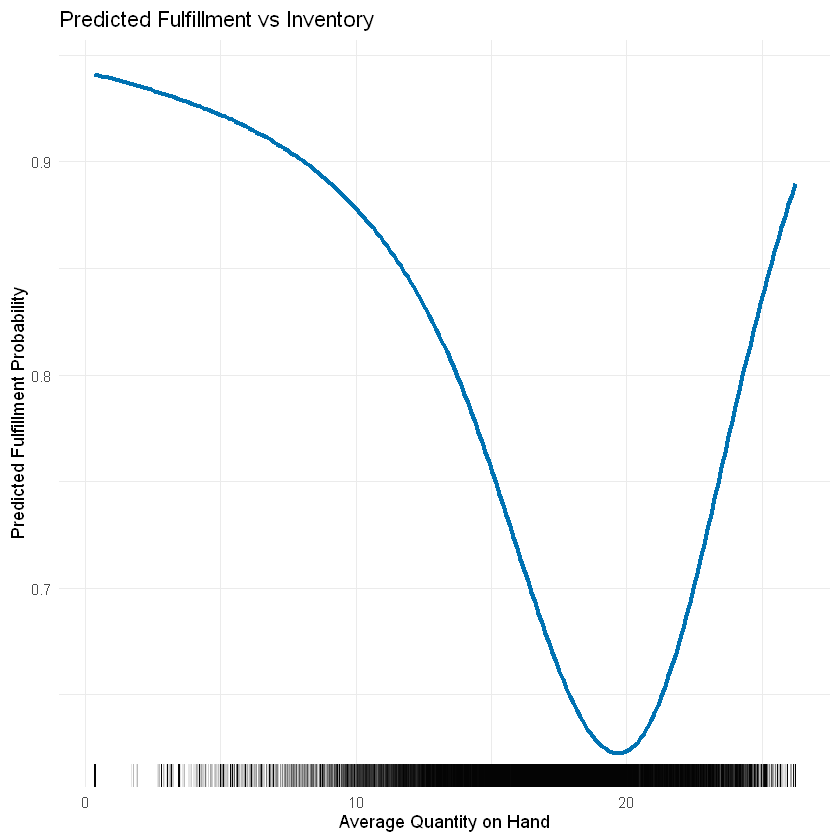

In [34]:
ggplot(prediction_df, aes(x = avg_quantity_on_hand, y = predicted_prob)) +
  geom_line(color = "#0072B2", size = 1.2) +
  geom_rug(data = order_level_df, aes(x = avg_quantity_on_hand), 
           inherit.aes = FALSE, sides = "b", alpha = 0.1) +
  labs(
    title = "Predicted Fulfillment vs Inventory",
    x = "Average Quantity on Hand",
    y = "Predicted Fulfillment Probability"
  ) +
  theme_minimal()

Order fulfillment probability decreases sharply as average inventory reaches moderate levels, before rising again with higher inventory. This confirms a nonlinear relationship that a linear model would miss.

With `avg_quantity_on_hand` established as a key predictor of fulfillment success - it becomes a strong mediating variable which bridges underlying causes and fulfillment outcomes.

The next phase is to ask:

"What factors drive average quantity on hand — and can they explain fulfillment failures upstream?"

Next I'll focus in on `supplier_id` and `item_id` pairs with averages taken for their `fulfilled_binary` outcomes, zoom out from the `order_items` data level.

### Predicting `avg_quantity_on_hand`

In [53]:
supplier_item_df <- order_item_final %>%
  select(-order_item_id, -order_id, -customer_id, -fulfilled_date,
         -fulfilled_quantity, -quantity, -order_date,
         -order_status, -item_status, -name, -category,
         -name_supplier, -category_supplier, unit_price) %>%
  group_by(supplier_id, item_id) %>%
  summarise(across(everything(), mean, na.rm = TRUE), .groups = "drop") %>%
  rename(avg_fulfilled_rate = fulfilled_binary)

Now with this dataframe I'll create a multilinear regression model.

In [80]:
model_qty_lm <- lm(
  avg_quantity_on_hand ~ item_failure_rate +
                         item_restock_weight +
                         supplier_failure_rate +
                         supplier_fulfillment_weight +
                         avg_backlog + stockouts,
  data = supplier_item_df
)
summary(model_qty_lm)


Call:
lm(formula = avg_quantity_on_hand ~ item_failure_rate + item_restock_weight + 
    supplier_failure_rate + supplier_fulfillment_weight + avg_backlog + 
    stockouts, data = supplier_item_df)

Residuals:
   Min     1Q Median     3Q    Max 
-5.087 -1.801 -0.134  1.781  6.699 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  7.185813   0.974664   7.373 6.78e-11 ***
item_failure_rate           -0.953455   1.678082  -0.568   0.5713    
item_restock_weight          3.160504   0.187999  16.811  < 2e-16 ***
supplier_failure_rate        0.319299   1.821691   0.175   0.8612    
supplier_fulfillment_weight -0.353410   0.165881  -2.131   0.0358 *  
avg_backlog                  0.017255   0.007559   2.283   0.0247 *  
stockouts                   -0.027075   0.005948  -4.552 1.61e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.352 on 93 degrees of freedom
Multiple R-squared

`item_restock_weight` seems to be the most influential and most significant by quite a margin. 

As `avg_quantity_on_hand` showed a nonlinear shape in predicting fulfillment outcomes - I'll also investigate these variables with polynomial terms.

In [81]:
model_qty_poly <- lm(
  avg_quantity_on_hand ~ poly(item_failure_rate, 2) +
                         poly(item_restock_weight, 2) +
                         poly(supplier_failure_rate, 2) +
                         poly(supplier_fulfillment_weight, 2) +
                         avg_backlog + stockouts,
  data = supplier_item_df
)
summary(model_qty_poly)


Call:
lm(formula = avg_quantity_on_hand ~ poly(item_failure_rate, 2) + 
    poly(item_restock_weight, 2) + poly(supplier_failure_rate, 
    2) + poly(supplier_fulfillment_weight, 2) + avg_backlog + 
    stockouts, data = supplier_item_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9919 -1.3601  0.2083  1.4041  4.2184 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            17.599544   0.777747  22.629  < 2e-16
poly(item_failure_rate, 2)1             0.128661   2.076845   0.062   0.9507
poly(item_failure_rate, 2)2            -2.736770   2.085065  -1.313   0.1927
poly(item_restock_weight, 2)1          65.892853   3.429523  19.213  < 2e-16
poly(item_restock_weight, 2)2         -16.933263   2.941989  -5.756 1.21e-07
poly(supplier_failure_rate, 2)1         0.522866   3.302500   0.158   0.8746
poly(supplier_failure_rate, 2)2        -0.339235   2.079343  -0.163   0.8708
poly(supplier_fulfillment_weight, 2

This confirms nonlinear influence (poly2 term significant)

In [79]:
rf_model <- randomForest(
  avg_quantity_on_hand ~ item_failure_rate +
                         item_restock_weight +
                         supplier_failure_rate +
                         supplier_fulfillment_weight +
                         avg_backlog + stockouts,
  data = supplier_item_df,
  importance = TRUE
)
importance(rf_model)


,%IncMSE,IncNodePurity
item_failure_rate,2.4865769,158.19938
item_restock_weight,26.5147029,2105.10730
supplier_failure_rate,0.5875097,73.89255
supplier_fulfillment_weight,0.1817112,77.30215
avg_backlog,13.7977028,1059.03728
stockouts,26.1937337,2180.83086


`item_restock_weight` is #1 in %IncMSE and #2 IncNodePurity — with `stockouts` being the other standout. `stockouts` has also showed significance in predicting `avg_quantity_on_hand` in the previous models.

I think it's fair to say at this point that there seems to be causal chains:

`item_restock_weight` ↑ → `avg_quantity_on_hand` ↑ → `fulfillment` ↑

`stockouts` ↑ → `avg_quantity_on_hand` ↓ → `fulfillment` ↓

## Export

If I want to use more visualisation focused tools like PowerBI or Tableau it may save me some PowerQuery to export my dataframes from this notebook.

In [84]:
write.csv(supplier_item_df, "data\\supplier_item_df.csv", row.names = FALSE)
write.csv(order_item_final, "data\\order_item_final.csv", row.names = FALSE)